<a href="https://colab.research.google.com/github/Fuad-Khan/2_Class_Religious_Abuse_Models/blob/main/2_class_Religious_BiLSTM_%2B_Attention_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BiLSTM + Attention + FastText

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 100, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,612,262 (25.22 MB)

 Trainable params: 6,612,262 (25.22 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 323s 966ms/step - accuracy: 0.7153 - loss: 1.3491 - val_accuracy: 0.9000 - val_loss: 0.7925
Epoch 2/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 346s 1s/step - accuracy: 0.9141 - loss: 0.7239 - val_accuracy: 0.9218 - val_loss: 0.5255
Epoch 3/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 361s 977ms/step - accuracy: 0.9428 - loss: 0.4637 - val_accuracy: 0.9303 - val_loss: 0.3804
Epoch 4/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 319s 968ms/step - accuracy: 0.9657 - loss: 0.2876 - val_accuracy: 0.9106 - val_loss: 0.3473
Epoch 5/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 321s 966ms/step - accuracy: 0.9786 - loss: 0.1796 - val_accuracy: 0.9214 - val_loss: 0.3025
Epoch 6/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 319s 957ms/step - accuracy: 0.9859 - loss: 0.1184 - val_accuracy: 0.9170 - val_loss: 0.3002
Epoch 7/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 340s 1s/step - accuracy: 0.9859 - loss: 0.0954 - val_accuracy: 0.9081 - val_loss: 0.3565
Epoch 8/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 309s 955ms/step - accuracy: 0.9905 - loss:

162/162 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step


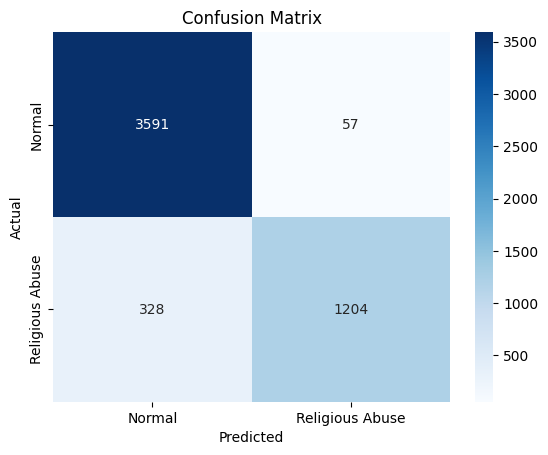

                 precision    recall  f1-score   support

         Normal       0.92      0.98      0.95      3648
Religious Abuse       0.95      0.79      0.86      1532

       accuracy                           0.93      5180
      macro avg       0.94      0.89      0.91      5180
   weighted avg       0.93      0.93      0.92      5180



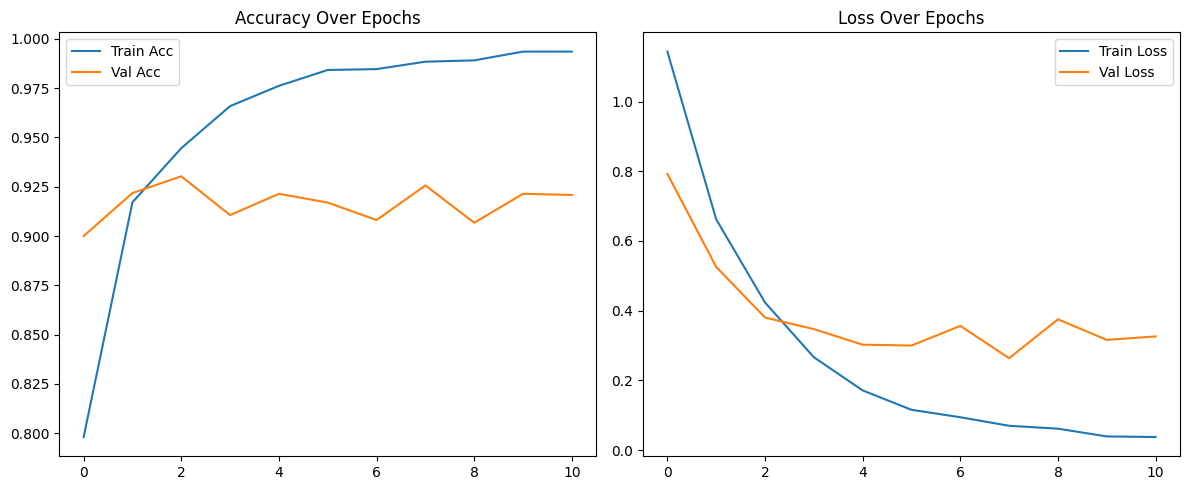

In [1]:
# 📚 Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import requests
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

# 🔽 Download FastText embeddings (Bangla)
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz"
filename = "cc.bn.300.vec.gz"
response = requests.get(url)
with open(filename, "wb") as f:
    f.write(response.content)

# 🧠 Custom Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

# 📁 Load cleaned data
file_path = "/content/drive/MyDrive/Research Paper/Data Preprocessing/2 Class/Cleaned_Labeled_Religious_Comments_Numeric.csv"
df = pd.read_csv(file_path)
df.dropna(subset=['comment', 'label_numeric'], inplace=True)

texts = df['comment'].astype(str).tolist()
labels = df['label_numeric'].tolist()

# 🎯 Label Encoding
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels), num_classes=2)

# 🔤 Tokenization & Padding
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x = pad_sequences(sequences, maxlen=max_len)

# ⛓ Load FastText embeddings
embedding_index = {}
with gzip.open(filename, 'rt', encoding='utf8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# 🔗 Embedding matrix
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 🧪 Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# ⚖️ Compute class weights
y_train_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights = dict(enumerate(class_weights))

# 🏗️ Model Architecture
input_ = Input(shape=(max_len,))
embedding = Embedding(input_dim=num_words,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      input_length=max_len,
                      trainable=True)(input_)

bilstm1 = Bidirectional(LSTM(128, return_sequences=True))(embedding)
bilstm2 = Bidirectional(LSTM(64, return_sequences=True))(bilstm1)
attention = Attention()(bilstm2)
drop = Dropout(0.5)(attention)
dense = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(drop)
output = Dense(2, activation='softmax')(dense)

model = Model(inputs=input_, outputs=output)

# 🧠 Compile with low LR Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 🛑 Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 🚀 Train
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=15,
                    batch_size=64,
                    class_weight=class_weights,
                    callbacks=[early_stopping])

# 💾 Save model
model.save("/content/drive/MyDrive/Research Paper/Models/2 Class/Hybrid Deep Learning Models/bilstm_attention_fasttext_bangla_2label_v2.h5")

# 🎯 Predict & Evaluate
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# 🧾 Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Religious Abuse'],
            yticklabels=['Normal', 'Religious Abuse'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 📊 Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Religious Abuse']))

# 📈 Accuracy & Loss Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# v3 BiLSTM + Attention + FastText + Class Weights + EarlyStopping (val_recall)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 100, 300)       │     6,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 100, 128)       │       186,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_4 (Attention)         │ (None, 128)            │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,195,494 (23.63 MB)

 Trainable params: 195,494 (763.65 KB)

 Non-trainable params: 6,000,000 (22.89 MB)

Epoch 1/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 97s 277ms/step - accuracy: 0.7833 - loss: 0.4961 - recall: 0.7833 - val_accuracy: 0.8687 - val_loss: 0.3250 - val_recall: 0.8687
Epoch 2/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 145s 288ms/step - accuracy: 0.8881 - loss: 0.2965 - recall: 0.8881 - val_accuracy: 0.8844 - val_loss: 0.2577 - val_recall: 0.8844
Epoch 3/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 136s 271ms/step - accuracy: 0.8950 - loss: 0.2705 - recall: 0.8950 - val_accuracy: 0.8983 - val_loss: 0.2386 - val_recall: 0.8983
Epoch 4/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 150s 296ms/step - accuracy: 0.9088 - loss: 0.2387 - recall: 0.9088 - val_accuracy: 0.9056 - val_loss: 0.2270 - val_recall: 0.9056
Epoch 5/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 135s 275ms/step - accuracy: 0.9000 - loss: 0.2663 - recall: 0.9000 - val_accuracy: 0.9151 - val_loss: 0.2065 - val_recall: 0.9151
Epoch 6/15
324/324 ━━━━━━━━━━━━━━━━━━━━ 89s 275ms/step - accuracy: 0.9103 - loss: 0.2278 - recall: 0.9103 - val_accuracy: 0.9147 - val_loss: 0.1985 - v

162/162 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step


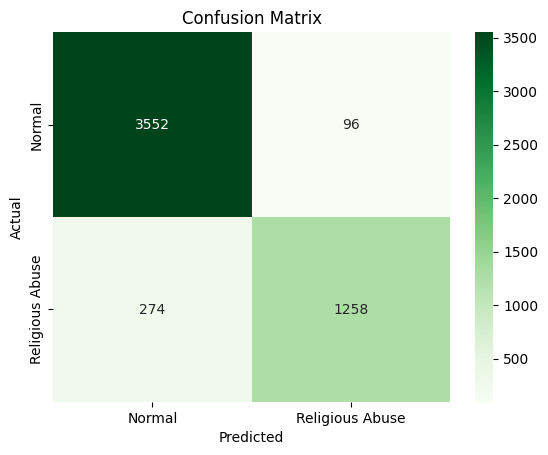

                 precision    recall  f1-score   support

         Normal       0.93      0.97      0.95      3648
Religious Abuse       0.93      0.82      0.87      1532

       accuracy                           0.93      5180
      macro avg       0.93      0.90      0.91      5180
   weighted avg       0.93      0.93      0.93      5180



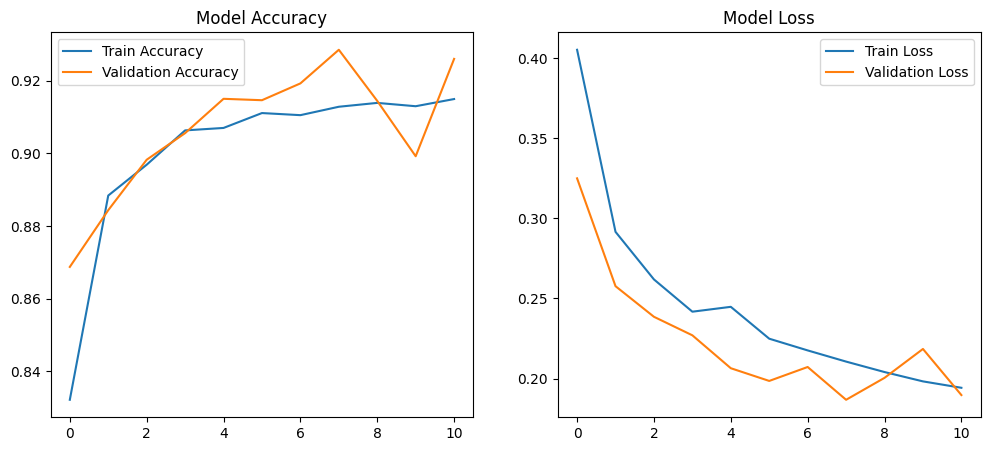

In [6]:
# Preparing the full code with class weights and early stopping based on validation recall.
# Note: Focal loss is provided but commented out for optional use.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
import tensorflow.keras.backend as K
import tensorflow as tf

# Download FastText embeddings (Bangla)
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz"
filename = "cc.bn.300.vec.gz"
response = requests.get(url)
with open(filename, "wb") as f:
    f.write(response.content)

# Attention Layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight',
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

# Optional Focal Loss
def focal_loss(gamma=2., alpha=.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        prob = tf.reduce_max(y_pred * y_true, axis=-1)
        loss = alpha * tf.pow(1. - prob, gamma) * cross_entropy
        return tf.reduce_mean(loss)
    return loss

# Load dataset
file_path = "/content/drive/MyDrive/Research Paper/Data Preprocessing/2 Class/Cleaned_Labeled_Religious_Comments_Numeric.csv"
df = pd.read_csv(file_path)
df.dropna(subset=['comment', 'label_numeric'], inplace=True)

texts = df['comment'].astype(str).tolist()
labels = df['label_numeric'].tolist()

# Label Encoding
le = LabelEncoder()
y = to_categorical(le.fit_transform(labels), num_classes=2)

# Tokenization
max_words = 20000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
x = pad_sequences(sequences, maxlen=max_len)

# Load FastText Embeddings
embedding_index = {}
with gzip.open(filename, 'rt', encoding='utf8') as f:
    next(f)
    for line in f:
        values = line.rstrip().split(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Embedding Matrix
embedding_dim = 300
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Train/Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Class Weights
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weights = dict(enumerate(class_weights))

# Build Model
input_ = Input(shape=(max_len,))
embedding = Embedding(input_dim=num_words,
                      output_dim=embedding_dim,
                      weights=[embedding_matrix],
                      input_length=max_len,
                      trainable=False)(input_)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
attention = Attention()(bilstm)
drop = Dropout(0.5)(attention)
dense = Dense(64, activation='relu')(drop)
output = Dense(2, activation='softmax')(dense)

model = Model(inputs=input_, outputs=output)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use focal_loss() here if needed
              metrics=['accuracy', Recall(name='recall')])
model.summary()

# Early Stopping Callback
early_stop = EarlyStopping(monitor='val_recall', mode='max',
                           patience=3, restore_best_weights=True)

# Train Model
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=15,
                    batch_size=64,
                    class_weight=class_weights,
                    callbacks=[early_stop])

# Save Model
model.save("/content/drive/MyDrive/Research Paper/Models/2 Class/Hybrid Deep Learning Models/bilstm_attention_fasttext_bangla_2label_improved_v3.h5")

# Evaluate
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Normal', 'Religious Abuse'],
            yticklabels=['Normal', 'Religious Abuse'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=['Normal', 'Religious Abuse']))

# Accuracy & Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()
